# Personalized Article Recommendation Engine (Example)

This notebook demonstrates how to use Pinecone's similarity search to create a simple personalized article or content recommender.

The goal is to create a recommendation engine that retrieves the best article recommendations for each user. When making recommendations with content-based filtering, we evaluate the user’s past behavior and the content items themselves. So in this example, users will be recommended articles that are similar to those they've already read.




## Install and Import Python Packages

In [1]:
!pip install --quiet sentence-transformers
!pip install --quiet wordcloud
!pip install --quiet pandas==1.2.3
!pip install --quiet swifter

In [2]:
import os
import pandas as pd
import numpy as np
import time
import swifter
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In the following sections, we will use Pinecone to easily build an article recommendation engine. Pinecone will be responsible for storing embeddings for articles, maintaining a live index of those vectors, and returning recommended articles on-demand. 

## Pinecone Installation and Setup

In [3]:
!pip install --quiet -U pinecone-client

In [4]:
import pinecone

In [5]:
# Load Pinecone API key
api_key = os.getenv("PINECONE_API_KEY") or "YOUR_API_KEY"
pinecone.init(api_key=api_key, environment='us-west1-gcp')

[Get a Pinecone API key](https://www.pinecone.io/start/) if you don’t have one already.

## Setting up Pinecone's Similarity Search Service


The typical workflow when using Pinecone:

1. Create an index.
2. Create a connection to the index, and start sending insert and query requests.

### Create an index

In [6]:
index_name = 'articles-recommendation'

In [7]:
# Check whether the index with the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

In [8]:
pinecone.create_index(index_name, dimension=300, metric="cosine", shards=1)

### Create the connection to the new index

In [10]:
index = pinecone.Index(index_name)
index.describe_index_stats()

{'dimension': 0, 'namespaces': {}}

## Upload articles
Next, we will prepare data for the Pinecone vector index, and insert it in batches.

###  Load data

The [dataset](https://components.one/datasets/all-the-news-2-news-articles-dataset/) used throughout this example contains 2.7 million news articles and essays from 27 American publications. 

Let's download the dataset.

In [11]:
!rm all-the-news-2-1.zip
!rm all-the-news-2-1.csv
!wget https://www.dropbox.com/s/cn2utnr5ipathhh/all-the-news-2-1.zip -q --show-progress
!unzip -q all-the-news-2-1.zip

### Use Ready Made Vector Embedding Model

Model used in this example is the [Average Word Embeddings Models](https://www.sbert.net/docs/pretrained_models.html#average-word-embeddings-models). This model allows us to create vector embeddings for each article. We will create the vectors using the title and the content of each article.

In [12]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('average_word_embeddings_komninos')

Using the complete dataset may require more time for the model to generate vector embeddings. We will use only a sample, but if you want to try uploading the whole dataset, set the **NROWS** flag to **None**.

In [13]:
NROWS = 200000      # number of rows to be loaded from the csv, set to None for loading all rows, reduce if you have a low amount of RAM or want a faster execution
BATCH_SIZE = 500    # batch size for upserting in batches

### Upload data in batches

Let's prepare data for upload.

Uploading the data may take a while, and depends on the network you use.

In [14]:
#%%time     

def prepare_data(data) -> pd.DataFrame:
    'Preprocesses data and prepares it for upsert.'
    
    # rename id column and remove unnecessary columns
    print("Preparing data...")
    data.rename(columns={"Unnamed: 0": "id"}, inplace = True)
    data.drop(columns=['Unnamed: 0.1', 'date'], inplace = True)

    # extract only first few sentences of each article for quicker vector calculations
    data['article'] = data['article'].fillna('')
    data['article'] = data.article.swifter.apply(lambda x: ' '.join(re.split(r'(?<=[.:;])\s', x)[:4]))
    data['title_article'] = data['title'] + data['article']
    
    # create a vector embedding based on title and article columns
    print('Encoding articles...')
    encoded_articles = model.encode(data['title_article'], show_progress_bar=True)
    data['article_vector'] = pd.Series(encoded_articles.tolist())
    
    return data


def upload_items(data):
    'Uploads data in batches.'
    print("Uploading items")
    
    # create a list of items for upload
    items_to_upload = [(str(row.id), row.article_vector) for i,row in data.iterrows()]
    
    # upsert
    for i in range(0, len(items_to_upload), BATCH_SIZE):
        index.upsert(vectors=items_to_upload[i:i+BATCH_SIZE])

    
def process_file(filename: str) -> pd.DataFrame:
    'Reads csv files in chunks, prepares and uploads data.'
    
    data = pd.read_csv(filename, nrows=NROWS)
    data = prepare_data(data)
    upload_items(data)
    return data
            
uploaded_data = process_file(filename='all-the-news-2-1.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Preparing data...


Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

Encoding articles...


Batches:   0%|          | 0/6250 [00:00<?, ?it/s]

Uploading items


In [15]:
# Print index statistics
index.describe_index_stats()

{'dimension': 300, 'namespaces': {'': {'vector_count': 200000}}}

## Querying

We will query the index for the specific users. The users are defined as a set of the articles that they previously read. More specifically, we will define 10 articles for each user, and based on the article embeddings, we will define a unique embedding for the user.

We will create three users and query Pinecone for each of them:
* User who likes to read Sport News
* User who likes to read Entertainment News
* User who likes to read Business News

Let's define mappings for titles, sections, and publications for each article.

In [16]:
titles_mapped = dict(zip(uploaded_data.id, uploaded_data.title))
sections_mapped = dict(zip(uploaded_data.id, uploaded_data.section))
publications_mapped = dict(zip(uploaded_data.id, uploaded_data.publication))

Also, we will define a function that uses *wordcloud* to visualize results.

In [17]:
def get_wordcloud_for_user(recommendations):

    stopwords = set(STOPWORDS).union([np.nan, 'NaN', 'S'])

    wordcloud = WordCloud(
                   max_words=50000, 
                   min_font_size =12, 
                   max_font_size=50, 
                   relative_scaling = 0.9, 
                   stopwords=set(STOPWORDS),
                   normalize_plurals= True
    )

    clean_titles = [word for word in recommendations.title.values if word not in stopwords]
    title_wordcloud = wordcloud.generate(' '.join(clean_titles))

    plt.imshow(title_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Let's query the Pinecone index using three users. 

### Query Sports User


Here is the example of previously read articles by this user:



,title,article,section,publication
2261,Son of Borg makes quiet debut on London grassc...,"LONDON (Reuters) - A blonde-haired, blue-eyed ...",Sports News,Reuters
12373,Cilic offers Nadal a Wimbledon reality check,LONDON (Reuters) - Spaniard Rafael Nadal got a...,Sports News,Reuters
17124,Perth confirmed as host for Fed Cup final,(Reuters) - Perth has been named host city for...,Sports News,Reuters
18411,Fed Cup gets revamp with 12-nation Finals in B...,LONDON (Reuters) - The Fed Cup’s existing form...,Sports News,Reuters
26574,Nadal to prepare for Wimbledon at Hurlingham e...,(Reuters) - World number two Rafa Nadal has en...,Sports News,Reuters
34957,Tennis Legend Margaret Court Went Off the Rail...,"Margaret Court, the most decorated tennis play...",Sports,Vice
35508,Puck City: The Enduring Success of Ice Hockey ...,This article originally appeared on VICE Sport...,Sports,Vice
38393,"As if by royal command, seven Britons make it ...",LONDON (Reuters) - Tennis fan the Duchess of C...,Sports News,Reuters
62445,"Williams fined $17,000 for U.S. Open code viol...",NEW YORK (Reuters) - Serena Williams has been ...,Sports News,Reuters
84122,Kyrgios still wrestling with his tennis soul a...,LONDON (Reuters) - Timothy Gallwey’s million-s...,Sports News,Reuters



This table contains recommended articles for the user:



,id,score,title,section,publication
0,138865,0.966407,Federer survives first-set wobble to down Wimb...,Sports News,Reuters
1,26574,0.965867,Nadal to prepare for Wimbledon at Hurlingham e...,Sports News,Reuters
2,12373,0.965307,Cilic offers Nadal a Wimbledon reality check,Sports News,Reuters
3,155913,0.963684,U.S. men likely to wander Wimbledon wilderness...,Sports News,Reuters
4,60613,0.962414,Auger-Aliassime powers past Tsitsipas into Que...,Sports News,Reuters
5,22764,0.962373,Serena headed to Wimbledon seeking return to form,Sports News,Reuters
6,71768,0.962168,"Venus, Serena, and the Power of Believing",Sports,Vice
7,2261,0.961590,Son of Borg makes quiet debut on London grassc...,Sports News,Reuters
8,45469,0.961451,Tennis: Barty a win away from world number one,Sports News,Reuters
9,55061,0.960677,"Warrior on court, diplomat off it, classy Bart...",Sports News,Reuters



A word-cloud representing the results:



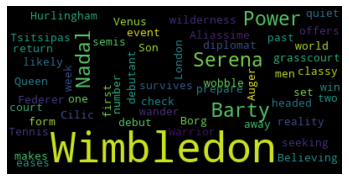

In [18]:
from statistics import mean


# first create a user who likes to read sport news about tennis
sport_user = uploaded_data.loc[((uploaded_data['section'] == 'Sports News' ) | 
                                (uploaded_data['section'] == 'Sports')) &
                                (uploaded_data['article'].str.contains('Tennis'))][:10]

print('\nHere is the example of previously read articles by this user:\n')
display(sport_user[['title', 'article', 'section', 'publication']])

# then create a vector for this user
a = sport_user['article_vector']
sport_user_vector = [*map(mean, zip(*a))]

# query the pinecone
query_results = index.query(queries=[sport_user_vector], top_k=10)

# print results
res = query_results.results[0]
ids = [match.id for match in res.matches]
scores = [match.score for match in res.matches]
df = pd.DataFrame({'id': ids, 
                   'score': scores,
                   'title': [titles_mapped[int(_id)] for _id in ids],
                   'section': [sections_mapped[int(_id)] for _id in ids],
                   'publication': [publications_mapped[int(_id)] for _id in ids]
                    })

print("\nThis table contains recommended articles for the user:\n")
display(df)
print("\nA word-cloud representing the results:\n")
get_wordcloud_for_user(df)

### Query Entertainment User


Here is the example of previously read articles by this user:



,title,article,section,publication
4977,A Canadian Man Is Pissed That His Son Ran Up a...,"A Pembroke, Ontario, gun shop owner is ""mad as...",Games,Vice
12016,'I Expect You to Die' is One of Virtual Realit...,The reason I bought a Vive over and Oculus ear...,Games,Vice
16078,Windows 10's Killer App? Xbox One Games,Microsoft's crusade to get the world to instal...,Tech by VICE,Vice
20318,Black Friday Not Your Thing? Play These Free G...,"It's Black Friday, the oh-so-American shopping...",Games,Vice
25785,Nintendo’s Win at E3 Shows That It's a Console...,"​ E3 has come and gone for 2016, the LA expo o...",Games,Vice
29653,You Can Smell Like a Gamer With Lynx’s New Xbo...,Gamers in Australia and New Zealand will soon ...,Games,Vice
33234,"It’s Old and It’s Clunky, But You Really Must ...","When Dragon's Dogma first popped up in 2012, t...",Games,Vice
34617,Nintendo’s Win at E3 Shows That It's a Console...,"E3 has come and gone for 2016, the LA expo of ...",Games,Vice
38608,PC Gaming Is Still Way Too Hard,Here's Motherboard's super simple guide to bui...,Tech by VICE,Vice
41444,Here’s Everything That Happened at the Xbox E3...,That's Xbox's Big Show for E3 2016 over and do...,Games,Vice



This table contains recommended articles for the user:



,id,score,title,section,publication
0,34617,0.966390,Nintendo’s Win at E3 Shows That It's a Console...,Games,Vice
1,63293,0.965053,A Title Card vs Six Teraflops: How Metroid Sto...,Games,Vice
2,25785,0.964193,Nintendo’s Win at E3 Shows That It's a Console...,Games,Vice
3,16771,0.963487,The Lo-Fi Flaws That Define Our Favorite Old G...,Games,Vice
4,38608,0.960349,PC Gaming Is Still Way Too Hard,Tech by VICE,Vice
5,121140,0.960174,Microsoft’s New Direction All Started With the...,Tech by VICE,Vice
6,160409,0.959802,Sometimes a David Bowie Song Gets Your Favorit...,Tech by VICE,Vice
7,29653,0.959628,You Can Smell Like a Gamer With Lynx’s New Xbo...,Games,Vice
8,156585,0.959381,"Google Takes Aim at PlayStation, Xbox With Gam...",Games,Vice
9,185864,0.958857,"The Switch Succeeds on Nintendo's Historic ""To...",Games,Vice



A word-cloud representing the results:



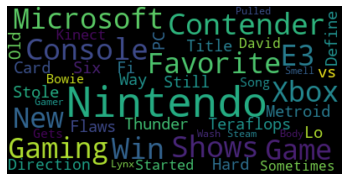

In [19]:
# first create a user who likes to read news about Xbox
entertainment_user = uploaded_data.loc[((uploaded_data['section'] == 'Entertainment') |
                                        (uploaded_data['section'] == 'Games') |
                                        (uploaded_data['section'] == 'Tech by VICE')) &
                                        (uploaded_data['article'].str.contains('Xbox'))][:10]

print('\nHere is the example of previously read articles by this user:\n')
display(entertainment_user[['title', 'article', 'section', 'publication']])

# then create a vector for this user
a = entertainment_user['article_vector']
entertainment_user_vector = [*map(mean, zip(*a))]

# query the pinecone
query_results = index.query(queries=[entertainment_user_vector], top_k=10)

# print results
res = query_results.results[0]
ids = [match.id for match in res.matches]
scores = [match.score for match in res.matches]
df = pd.DataFrame({'id': ids, 
                   'score': scores,
                   'title': [titles_mapped[int(_id)] for _id in ids],
                   'section': [sections_mapped[int(_id)] for _id in ids],
                   'publication': [publications_mapped[int(_id)] for _id in ids]
                    })

print("\nThis table contains recommended articles for the user:\n")
display(df)
print("\nA word-cloud representing the results:\n")
get_wordcloud_for_user(df)

### Query Business User


Here is the example of previously read articles by this user:



,title,article,section,publication
370,Wall St. falls as investors eye a united hawki...,NEW YORK (Reuters) - Wall Street’s major index...,Business News,Reuters
809,Oil surges on tanker attacks; stocks rise on F...,NEW YORK (Reuters) - Oil futures rose on Thurs...,Business News,Reuters
885,A look at Tesla's nine-member board,(Reuters) - Tesla Inc’s board has named a spec...,Business News,Reuters
1049,Home Depot posts rare sales miss as delayed sp...,(Reuters) - Home Depot Inc (HD.N) on Tuesday m...,Business News,Reuters
1555,PepsiCo's mini-sized sodas boost quarterly res...,(Reuters) - PepsiCo Inc’s (PEP.O) quarterly re...,Business News,Reuters
1638,Wall Street extends rally on U.S.-China trade ...,NEW YORK (Reuters) - U.S. stocks rallied on Fr...,Business News,Reuters
1900,U.S. plans limits on Chinese investment in U.S...,WASHINGTON (Reuters) - The U.S. Treasury Depar...,Business News,Reuters
2109,"Exxon Mobil, Chevron dogged by refining, chemi...",HOUSTON (Reuters) - Exxon Mobil Corp and Chevr...,Business News,Reuters
2286,Wall Street soars on U.S. rate cut hopes,NEW YORK (Reuters) - Wall Street’s three major...,Business News,Reuters
2563,Apple shares drop on iPhone suppliers' warnings,(Reuters) - Apple Inc (AAPL.O) shares fell to ...,Business News,Reuters



This table contains recommended articles for the user:



,id,score,title,section,publication
0,131603,0.970930,US STOCKS-Wall Street muted as rate cut bets t...,Market News,Reuters
1,93287,0.970408,MONEY MARKETS-U.S. rate-cut bets in June slip ...,Bonds News,Reuters
2,159587,0.970357,"Wall Street ekes out gain, Apple cuts revenue ...",Business News,Reuters
3,45533,0.969199,Wall Street wavers as tech gives ground and in...,Business News,Reuters
4,147320,0.968577,Dented Fed rate cut hopes drag on stocks; doll...,Davos,Reuters
5,152313,0.968503,MIDEAST - Factors to watch - July 9,Earnings Season,Reuters
6,34583,0.968178,Global stocks rally after speech by Fed's Powe...,Business News,Reuters
7,89976,0.968087,"Stocks, yields rise after deal announced to en...",Business News,Reuters
8,96107,0.968018,Wall Street surges on higher oil after U.S. qu...,Business News,Reuters
9,51197,0.967809,"UPDATE 1-Weak economic data, rate cut expectat...",Market News,Reuters



A word-cloud representing the results:



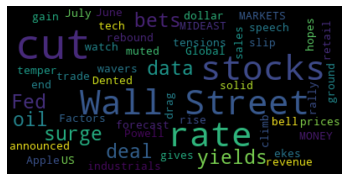

In [20]:
# first create a user who likes to read about Wall Street business news
business_user = uploaded_data.loc[((uploaded_data['section'] == 'Business News')|
                                   (uploaded_data['section'] == 'business')) &
                                   (uploaded_data['article'].str.contains('Wall Street'))][:10]

print('\nHere is the example of previously read articles by this user:\n')
display(business_user[['title', 'article', 'section', 'publication']])

# then create a vector for this user
a = business_user['article_vector']
business_user_vector = [*map(mean, zip(*a))]

# query the pinecone
query_results = index.query(queries=[business_user_vector], top_k=10)

# print results
res = query_results.results[0]
ids = [match.id for match in res.matches]
scores = [match.score for match in res.matches]
df = pd.DataFrame({'id': ids, 
                   'score': scores,
                   'title': [titles_mapped[int(_id)] for _id in ids],
                   'section': [sections_mapped[int(_id)] for _id in ids],
                   'publication': [publications_mapped[int(_id)] for _id in ids]
                    })

print("\nThis table contains recommended articles for the user:\n")
display(df)
print("\nA word-cloud representing the results:\n")
get_wordcloud_for_user(df)

### Query Results

We can see that each user's recommendations have a high similarity to what the user actually reads. A user who likes Tennis news has plenty of Tennis news recommendations. A user who likes to read about Xbox has that kind of news. And a business user has plenty of Wall Street news that he/she enjoys. 

From the word-cloud, you can see the most frequent words that appear in the recommended articles' titles. 

Since we used only the title and the content of the article to define the embeddings, and we did not take publications and sections into account, a user may get recommendations from a publication/section that he does not regularly read. You may try adding this information when creating embeddings as well and check your query results then!

Also, you may notice that some articles appear in the recommendations, although the user has already read them. These articles could be removed as part of postprocessing the query results, in case you prefer not to see them in the recommendations.

## Delete the index

Delete the index once you are sure that you do not want to use it anymore. Once it is deleted, you cannot use it again.



In [21]:
pinecone.delete_index(index_name)